In [1]:
!pip install networkx
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 27.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import warnings
import networkx as nx
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to node embeddings.
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_length, d_model)
        Returns:
            Tensor of shape (batch_size, seq_length, d_model)
        """
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerModel(nn.Module):
    """
    Transformer model that predicts pheromone matrix given node coordinates.
    """
    def __init__(self, num_nodes, d_model=128, nhead=8, num_layers=8):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(2, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.output_projection = nn.Linear(d_model, d_model)
        self.final_activation = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, num_nodes, 2)  # Node coordinates
        Returns:
            pheromone_matrix: Tensor of shape (batch_size, num_nodes, num_nodes)
        """
        x = self.input_projection(x)
        x = x * np.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.output_projection(x)
        pheromone_matrix = torch.matmul(x, x.transpose(1, 2))
        pheromone_matrix = self.final_activation(pheromone_matrix)
        return pheromone_matrix


In [17]:
class StandardAntColonyOptimizer:
    """
    Implements the standard Ant Colony Optimization algorithm for TSP.
    Used for generating synthetic data and serving as a baseline.
    """
    def __init__(self, num_nodes, distance_matrix, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        self.pheromone = np.ones((num_nodes, num_nodes))
        self.best_distance = float('inf')
        self.best_solution = None

    def optimize(self, iterations=50):
        """
        Runs the ACO algorithm for a specified number of iterations.
        """
        for iteration in range(iterations):
            all_solutions = []
            all_distances = []
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                distance = self.calculate_total_distance(solution)
                all_solutions.append(solution)
                all_distances.append(distance)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = solution
            self.update_pheromone(all_solutions, all_distances)
        return self.best_solution, self.best_distance

    def construct_solution(self):
        """
        Constructs a solution (tour) by probabilistically selecting the next node based on pheromone and heuristic.
        """
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes)
        solution.append(current_node)
        visited.add(current_node)

        for _ in range(self.num_nodes - 1):
            probabilities = self.calculate_transition_probabilities(current_node, visited)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited):
        """
        Calculates the probability of moving to each node not yet visited.
        """
        pheromone = self.pheromone[current_node] ** self.alpha
        heuristic = (1.0 / (self.distance_matrix[current_node] + 1e-10)) ** self.beta
        pheromone[list(visited)] = 0
        heuristic[list(visited)] = 0

        numerator = pheromone * heuristic
        denominator = np.sum(numerator)
        if denominator == 0:
            probabilities = np.ones(self.num_nodes) / self.num_nodes
        else:
            probabilities = numerator / denominator
        return probabilities

    def update_pheromone(self, solutions, distances):
        """
        Updates pheromone levels based on the solutions found by ants.
        """
        self.pheromone *= (1 - self.evaporation_rate)

        for solution, distance in zip(solutions, distances):
            pheromone_increment = self.Q / distance
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_increment
            from_node = solution[-1]
            to_node = solution[0]
            self.pheromone[from_node][to_node] += pheromone_increment

    def calculate_total_distance(self, solution):
        """
        Calculates the total distance of the tour.
        """
        distance = 0.0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]
        return distance

class ImprovedAntColonyOptimizer:
    """
    Enhanced ACO algorithm where the initial pheromone matrix is predicted by the Transformer model.
    """
    def __init__(self, num_nodes, distance_matrix, initial_pheromone=None, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        if initial_pheromone is not None:
            self.pheromone = initial_pheromone  # Use the provided initial pheromone matrix
        else:
            self.pheromone = np.ones((num_nodes, num_nodes))  # Initialize pheromone levels uniformly
        self.best_distance = float('inf')
        self.best_solution = None

    def optimize(self, iterations=50):
        """
        Runs the DeepACO algorithm for a specified number of iterations.
        """
        for iteration in range(iterations):
            all_solutions = []
            all_distances = []
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                distance = self.calculate_total_distance(solution)
                all_solutions.append(solution)
                all_distances.append(distance)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = solution
            self.update_pheromone(all_solutions, all_distances)
        return self.best_solution, self.best_distance

    def construct_solution(self):
        """
        Constructs a solution (tour) by probabilistically selecting the next node based on pheromone and heuristic.
        """
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes)
        solution.append(current_node)
        visited.add(current_node)

        for _ in range(self.num_nodes - 1):
            probabilities = self.calculate_transition_probabilities(current_node, visited)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited):
        """
        Calculates the probability of moving to each node not yet visited.
        """
        pheromone = self.pheromone[current_node] ** self.alpha
        heuristic = (1.0 / (self.distance_matrix[current_node] + 1e-10)) ** self.beta
        pheromone[list(visited)] = 0
        heuristic[list(visited)] = 0

        numerator = pheromone * heuristic
        denominator = np.sum(numerator)
        if denominator == 0:
            probabilities = np.ones(self.num_nodes) / self.num_nodes
        else:
            probabilities = numerator / denominator
        return probabilities

    def update_pheromone(self, solutions, distances):
        """
        Updates pheromone levels based on the solutions found by ants.
        """
        self.pheromone *= (1 - self.evaporation_rate)

        for solution, distance in zip(solutions, distances):
            pheromone_increment = self.Q / distance
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_increment
            from_node = solution[-1]
            to_node = solution[0]
            self.pheromone[from_node][to_node] += pheromone_increment

    def calculate_total_distance(self, solution):
        """
        Calculates the total distance of the tour.
        """
        distance = 0.0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]
        return distance

In [18]:
def generate_tsp_solutions(num_nodes, num_samples=100):
    """
    Generates TSP solutions and pheromone matrices for randomly generated node coordinates.
    Returns node coordinates and corresponding pheromone matrices.
    """
    coordinates_list = []
    pheromone_matrices = []
    for _ in range(num_samples):
        # Generate random coordinates for nodes
        coordinates = np.random.rand(num_nodes, 2)
        coordinates_list.append(coordinates)
        # Compute Euclidean distance matrix
        distance_matrix = np.sqrt(
            (coordinates[:, np.newaxis, 0] - coordinates[np.newaxis, :, 0]) ** 2 +
            (coordinates[:, np.newaxis, 1] - coordinates[np.newaxis, :, 1]) ** 2
        )
        # Solve TSP
        solution = solve_tsp(num_nodes, distance_matrix)
        if solution:
            pheromone_matrices.append(solution_to_pheromone_matrix(solution, num_nodes))
        else:
            print("No solution found for a sample.")
    return np.array(coordinates_list), np.array(pheromone_matrices)

def solve_tsp(num_nodes, distance_matrix):
    """
    Solves the TSP for the given distance matrix using OR-Tools.
    Returns the optimal tour as a list of node indices.
    """
    manager = pywrapcp.RoutingIndexManager(num_nodes, 1, 0)

    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node] * 1e6)

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = 10
    search_parameters.solution_limit = 1
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            index = solution.Value(routing.NextVar(index))
        return route
    else:
        print("No solution found!")
        return None

def solution_to_pheromone_matrix(solution, num_nodes):
    """
    Converts a single solution to a pheromone matrix.
    """
    pheromone = np.zeros((num_nodes, num_nodes))
    for i in range(len(solution) - 1):
        from_node = solution[i]
        to_node = solution[i + 1]
        pheromone[from_node][to_node] += 1
    # Complete the tour
    from_node = solution[-1]
    to_node = solution[0]
    pheromone[from_node][to_node] += 1
    # Normalize pheromone
    pheromone /= pheromone.max() if pheromone.max() > 0 else 1
    return pheromone

In [20]:
def run_experiment(node_sizes, num_trials=50, iterations=100, num_ants=50, alpha=1.0, beta=2.0, evaporation_rate=0.3, Q=100):
    """
    Runs experiments comparing StandardACO and DeepACO across multiple node sizes.
    Prints comparisons for each trial and plots the results.
    """
    results = {}

    for num_nodes in node_sizes:
        print(f"\n=== Node Size: {num_nodes} ===")

        print("Generating synthetic data for training...")
        coordinates_list, pheromone_matrices = generate_tsp_solutions(
            num_nodes=num_nodes,
            num_samples=1000
        )

        split_index = int(0.8 * len(coordinates_list))
        train_coords = coordinates_list[:split_index]
        val_coords = coordinates_list[split_index:]
        train_pheromones = pheromone_matrices[:split_index]
        val_pheromones = pheromone_matrices[split_index:]

        train_coords_tensor = torch.tensor(train_coords, dtype=torch.float).to(device)
        train_pheromone_tensors = torch.tensor(train_pheromones, dtype=torch.float).to(device)
        val_coords_tensor = torch.tensor(val_coords, dtype=torch.float).to(device)
        val_pheromone_tensors = torch.tensor(val_pheromones, dtype=torch.float).to(device)

        model = TransformerModel(num_nodes=num_nodes).to(device)
        criterion = nn.MSELoss()
        optimizer_model = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_model, 'min', patience=5, factor=0.5)

        print("Training Transformer Model...")
        epochs = 50
        batch_size = 32
        num_samples = train_coords_tensor.size(0)
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            model.train()
            permutation = torch.randperm(num_samples)
            train_loss = 0.0
            for i in range(0, num_samples, batch_size):
                indices = permutation[i:i+batch_size]
                input_batch = train_coords_tensor[indices]
                target_batch = train_pheromone_tensors[indices]

                optimizer_model.zero_grad()
                output = model(input_batch)
                loss = criterion(output, target_batch)
                loss.backward()
                optimizer_model.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / (num_samples / batch_size)

            model.eval()
            with torch.no_grad():
                val_output = model(val_coords_tensor)
                val_loss = criterion(val_output, val_pheromone_tensors).item()

            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                torch.save(model.state_dict(), f'best_model_{num_nodes}.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))

        results[num_nodes] = {'StandardACO': [], 'DeepACO': []}

        print(f"Running {num_trials} trials for node size {num_nodes}...")
        for trial in tqdm(range(num_trials), desc=f"Trials for node size {num_nodes}"):
            trial_number = trial + 1
            coordinates = np.random.rand(num_nodes, 2)
            distance_matrix = np.sqrt(
                (coordinates[:, np.newaxis, 0] - coordinates[np.newaxis, :, 0]) ** 2 +
                (coordinates[:, np.newaxis, 1] - coordinates[np.newaxis, :, 1]) ** 2
            )

            coordinates_input = torch.tensor(coordinates[np.newaxis, :, :], dtype=torch.float).to(device)
            with torch.no_grad():
                model.eval()
                predicted_pheromone = model(coordinates_input)
            predicted_pheromone_np = predicted_pheromone.cpu().numpy()[0]

            predicted_pheromone_np -= predicted_pheromone_np.min()
            predicted_pheromone_np /= predicted_pheromone_np.max() if predicted_pheromone_np.max() > 0 else 1
            predicted_pheromone_np += 1e-6

            standard_aco = StandardAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                num_ants=num_ants,
                alpha=alpha,
                beta=beta,
                evaporation_rate=evaporation_rate,
                Q=Q
            )
            deep_aco = ImprovedAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                initial_pheromone=predicted_pheromone_np,
                num_ants=num_ants,
                alpha=alpha,
                beta=beta,
                evaporation_rate=evaporation_rate,
                Q=Q
            )

            _, best_distance_standard = standard_aco.optimize(iterations=iterations)
            _, best_distance_deep = deep_aco.optimize(iterations=iterations)

            results[num_nodes]['StandardACO'].append(best_distance_standard)
            results[num_nodes]['DeepACO'].append(best_distance_deep)

            print(f"Trial {trial_number}: StandardACO Best Distance = {best_distance_standard:.4f}, DeepACO Best Distance = {best_distance_deep:.4f}")

        # Plotting results for this node size
        plt.figure(figsize=(10, 6))
        plt.plot(results[num_nodes]['StandardACO'], label='StandardACO', marker='o')
        plt.plot(results[num_nodes]['DeepACO'], label='DeepACO', marker='s')
        plt.title(f"Best Distances for Node Size: {num_nodes}")
        plt.xlabel("Trial")
        plt.ylabel("Best Distance")
        plt.legend()
        plt.grid(True)
        plt.show()

        del model

    return results


In [21]:
def perform_statistical_tests(results):
    """
    Performs Wilcoxon signed-rank tests for each node size.
    Returns a dictionary of p-values.
    """
    node_sizes = sorted(results.keys())
    p_values = {}

    for num_nodes in node_sizes:
        standard = results[num_nodes]['StandardACO']
        deep = results[num_nodes]['DeepACO']
        stat, p = stats.wilcoxon(standard, deep)
        p_values[num_nodes] = p
        print(f"Node Size {num_nodes}: p-value = {p:.4e}")

    return p_values

In [22]:
def plot_results(results, p_values):
    """
    Plots average best distances for StandardACO and DeepACO across node sizes.
    Annotates significance based on p-values.
    """
    node_sizes = sorted(results.keys())
    standard_means = [np.mean(results[size]['StandardACO']) for size in node_sizes]
    deep_means = [np.mean(results[size]['DeepACO']) for size in node_sizes]
    standard_stds = [np.std(results[size]['StandardACO']) for size in node_sizes]
    deep_stds = [np.std(results[size]['DeepACO']) for size in node_sizes]

    x = np.arange(len(node_sizes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, standard_means, width, yerr=standard_stds, label='Standard ACO', capsize=5, color='skyblue')
    rects2 = ax.bar(x + width/2, deep_means, width, yerr=deep_stds, label='DeepACO (Transformer)', capsize=5, color='salmon')

    ax.set_ylabel('Average Best Distance')
    ax.set_xlabel('Number of Nodes')
    ax.set_title('Comparison of StandardACO vs. DeepACO Across Different Node Sizes')
    ax.set_xticks(x)
    ax.set_xticklabels(node_sizes)
    ax.legend()

    for i, size in enumerate(node_sizes):
        p = p_values[size]
        if p < 0.001:
            significance = '***'
        elif p < 0.01:
            significance = '**'
        elif p < 0.05:
            significance = '*'
        else:
            significance = 'ns'
        ax.text(x[i], max(standard_means[i], deep_means[i]) + max(standard_stds[i], deep_stds[i]) + 0.05, significance, ha='center', va='bottom', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()


=== Node Size: 30 ===
Generating synthetic data for training...
Training Transformer Model...
Epoch 1/50, Train Loss: 252.7519, Val Loss: 1.3190
Epoch 2/50, Train Loss: 1.0277, Val Loss: 0.0952
Epoch 3/50, Train Loss: 0.5242, Val Loss: 0.0371
Epoch 4/50, Train Loss: 0.4379, Val Loss: 0.0325
Epoch 5/50, Train Loss: 0.3568, Val Loss: 0.0323
Epoch 6/50, Train Loss: 0.2518, Val Loss: 0.0323
Epoch 7/50, Train Loss: 0.2054, Val Loss: 0.0322
Epoch 8/50, Train Loss: 0.1891, Val Loss: 0.0324
Epoch 9/50, Train Loss: 0.1802, Val Loss: 0.0324
Epoch 10/50, Train Loss: 0.1702, Val Loss: 0.0324
Epoch 11/50, Train Loss: 0.1614, Val Loss: 0.0326
Epoch 12/50, Train Loss: 0.1527, Val Loss: 0.0325
Epoch 13/50, Train Loss: 0.1459, Val Loss: 0.0323
Epoch 14/50, Train Loss: 0.1399, Val Loss: 0.0327
Epoch 15/50, Train Loss: 0.1355, Val Loss: 0.0326
Epoch 16/50, Train Loss: 0.1322, Val Loss: 0.0326
Epoch 17/50, Train Loss: 0.1291, Val Loss: 0.0327
Early stopping triggered.
Running 30 trials for node size 30..

Trials for node size 30:   3%|▎         | 1/30 [00:03<01:32,  3.19s/it]

Trial 1: StandardACO Best Distance = 4.3701, DeepACO Best Distance = 4.3927


Trials for node size 30:   7%|▋         | 2/30 [00:06<01:27,  3.14s/it]

Trial 2: StandardACO Best Distance = 4.9373, DeepACO Best Distance = 4.9373


Trials for node size 30:  10%|█         | 3/30 [00:09<01:28,  3.27s/it]

Trial 3: StandardACO Best Distance = 4.2133, DeepACO Best Distance = 4.0630


Trials for node size 30:  13%|█▎        | 4/30 [00:12<01:23,  3.20s/it]

Trial 4: StandardACO Best Distance = 4.9254, DeepACO Best Distance = 4.9206


Trials for node size 30:  17%|█▋        | 5/30 [00:15<01:19,  3.19s/it]

Trial 5: StandardACO Best Distance = 4.9281, DeepACO Best Distance = 4.8127


Trials for node size 30:  20%|██        | 6/30 [00:19<01:15,  3.16s/it]

Trial 6: StandardACO Best Distance = 4.7993, DeepACO Best Distance = 4.6926


Trials for node size 30:  23%|██▎       | 7/30 [00:22<01:12,  3.14s/it]

Trial 7: StandardACO Best Distance = 4.8181, DeepACO Best Distance = 4.7909


Trials for node size 30:  27%|██▋       | 8/30 [00:25<01:08,  3.12s/it]

Trial 8: StandardACO Best Distance = 5.1879, DeepACO Best Distance = 5.2246


Trials for node size 30:  30%|███       | 9/30 [00:28<01:05,  3.10s/it]

Trial 9: StandardACO Best Distance = 5.2039, DeepACO Best Distance = 5.2027


Trials for node size 30:  33%|███▎      | 10/30 [00:31<01:01,  3.09s/it]

Trial 10: StandardACO Best Distance = 4.8122, DeepACO Best Distance = 4.8229


Trials for node size 30:  37%|███▋      | 11/30 [00:34<00:58,  3.08s/it]

Trial 11: StandardACO Best Distance = 4.2717, DeepACO Best Distance = 4.4488


Trials for node size 30:  40%|████      | 12/30 [00:37<00:55,  3.08s/it]

Trial 12: StandardACO Best Distance = 5.2035, DeepACO Best Distance = 5.2397


Trials for node size 30:  43%|████▎     | 13/30 [00:40<00:52,  3.10s/it]

Trial 13: StandardACO Best Distance = 4.8174, DeepACO Best Distance = 4.5649


Trials for node size 30:  47%|████▋     | 14/30 [00:43<00:49,  3.08s/it]

Trial 14: StandardACO Best Distance = 5.0760, DeepACO Best Distance = 4.9564


Trials for node size 30:  50%|█████     | 15/30 [00:46<00:46,  3.08s/it]

Trial 15: StandardACO Best Distance = 4.6365, DeepACO Best Distance = 4.6261


Trials for node size 30:  53%|█████▎    | 16/30 [00:49<00:43,  3.11s/it]

Trial 16: StandardACO Best Distance = 4.3452, DeepACO Best Distance = 4.4115


Trials for node size 30:  57%|█████▋    | 17/30 [00:53<00:40,  3.11s/it]

Trial 17: StandardACO Best Distance = 5.0015, DeepACO Best Distance = 4.9254


Trials for node size 30:  60%|██████    | 18/30 [00:56<00:37,  3.10s/it]

Trial 18: StandardACO Best Distance = 4.4400, DeepACO Best Distance = 4.3134


Trials for node size 30:  63%|██████▎   | 19/30 [00:59<00:33,  3.08s/it]

Trial 19: StandardACO Best Distance = 4.8363, DeepACO Best Distance = 4.9535


Trials for node size 30:  67%|██████▋   | 20/30 [01:02<00:31,  3.11s/it]

Trial 20: StandardACO Best Distance = 4.6728, DeepACO Best Distance = 4.5820


Trials for node size 30:  70%|███████   | 21/30 [01:05<00:27,  3.09s/it]

Trial 21: StandardACO Best Distance = 4.2211, DeepACO Best Distance = 4.1672


Trials for node size 30:  73%|███████▎  | 22/30 [01:08<00:24,  3.09s/it]

Trial 22: StandardACO Best Distance = 4.8558, DeepACO Best Distance = 4.9353


Trials for node size 30:  77%|███████▋  | 23/30 [01:11<00:21,  3.09s/it]

Trial 23: StandardACO Best Distance = 5.0377, DeepACO Best Distance = 5.1343


Trials for node size 30:  80%|████████  | 24/30 [01:14<00:18,  3.10s/it]

Trial 24: StandardACO Best Distance = 4.2730, DeepACO Best Distance = 4.2666


Trials for node size 30:  83%|████████▎ | 25/30 [01:17<00:15,  3.09s/it]

Trial 25: StandardACO Best Distance = 4.5540, DeepACO Best Distance = 4.5371


Trials for node size 30:  87%|████████▋ | 26/30 [01:20<00:12,  3.09s/it]

Trial 26: StandardACO Best Distance = 4.9988, DeepACO Best Distance = 5.3508


Trials for node size 30:  90%|█████████ | 27/30 [01:23<00:09,  3.09s/it]

Trial 27: StandardACO Best Distance = 4.8425, DeepACO Best Distance = 4.8836


Trials for node size 30:  93%|█████████▎| 28/30 [01:27<00:06,  3.11s/it]

Trial 28: StandardACO Best Distance = 4.4269, DeepACO Best Distance = 4.4541


Trials for node size 30:  97%|█████████▋| 29/30 [01:30<00:03,  3.11s/it]

Trial 29: StandardACO Best Distance = 4.9312, DeepACO Best Distance = 4.9735


Trials for node size 30: 100%|██████████| 30/30 [01:33<00:00,  3.11s/it]

Trial 30: StandardACO Best Distance = 4.5098, DeepACO Best Distance = 4.5248


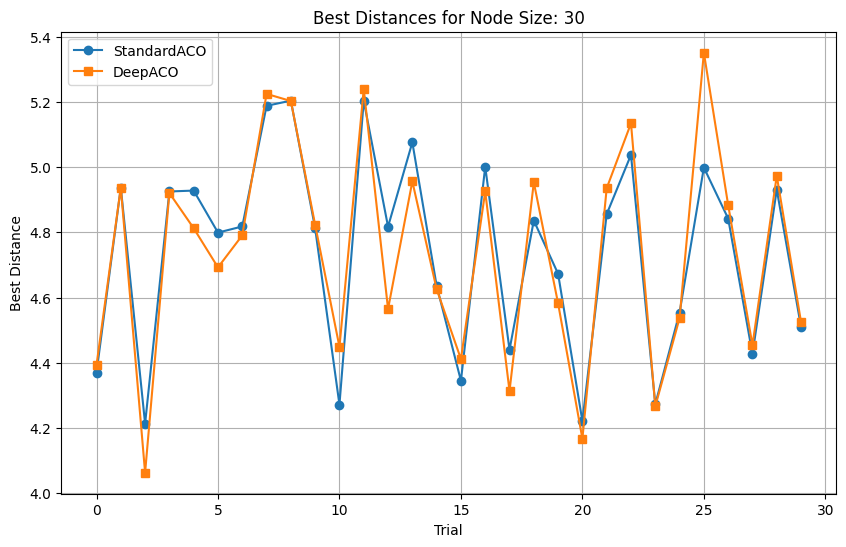


=== Node Size: 35 ===
Generating synthetic data for training...
Training Transformer Model...
Epoch 1/50, Train Loss: 216.7092, Val Loss: 1.6461
Epoch 2/50, Train Loss: 1.0324, Val Loss: 0.0848
Epoch 3/50, Train Loss: 0.4977, Val Loss: 0.0302
Epoch 4/50, Train Loss: 0.4000, Val Loss: 0.0278
Epoch 5/50, Train Loss: 0.3258, Val Loss: 0.0278
Epoch 6/50, Train Loss: 0.2313, Val Loss: 0.0278
Epoch 7/50, Train Loss: 0.1754, Val Loss: 0.0278
Epoch 8/50, Train Loss: 0.1591, Val Loss: 0.0278
Epoch 9/50, Train Loss: 0.1499, Val Loss: 0.0279
Epoch 10/50, Train Loss: 0.1391, Val Loss: 0.0278
Epoch 11/50, Train Loss: 0.1325, Val Loss: 0.0279
Epoch 12/50, Train Loss: 0.1273, Val Loss: 0.0278
Epoch 13/50, Train Loss: 0.1222, Val Loss: 0.0278
Epoch 14/50, Train Loss: 0.1185, Val Loss: 0.0278
Epoch 15/50, Train Loss: 0.1142, Val Loss: 0.0278
Epoch 16/50, Train Loss: 0.1108, Val Loss: 0.0278
Epoch 17/50, Train Loss: 0.1075, Val Loss: 0.0278
Epoch 18/50, Train Loss: 0.1053, Val Loss: 0.0278
Epoch 19/50,

Trials for node size 35:   3%|▎         | 1/30 [00:03<01:49,  3.77s/it]

Trial 1: StandardACO Best Distance = 4.8738, DeepACO Best Distance = 4.8326


Trials for node size 35:   7%|▋         | 2/30 [00:07<01:44,  3.72s/it]

Trial 2: StandardACO Best Distance = 5.2279, DeepACO Best Distance = 5.1882


Trials for node size 35:  10%|█         | 3/30 [00:11<01:39,  3.68s/it]

Trial 3: StandardACO Best Distance = 5.0237, DeepACO Best Distance = 5.0002


Trials for node size 35:  13%|█▎        | 4/30 [00:14<01:37,  3.74s/it]

Trial 4: StandardACO Best Distance = 5.1452, DeepACO Best Distance = 5.1021


Trials for node size 35:  17%|█▋        | 5/30 [00:18<01:32,  3.72s/it]

Trial 5: StandardACO Best Distance = 4.3526, DeepACO Best Distance = 4.2860


Trials for node size 35:  20%|██        | 6/30 [00:22<01:28,  3.71s/it]

Trial 6: StandardACO Best Distance = 4.6451, DeepACO Best Distance = 4.5970


Trials for node size 35:  23%|██▎       | 7/30 [00:26<01:26,  3.74s/it]

Trial 7: StandardACO Best Distance = 5.3822, DeepACO Best Distance = 5.4243


Trials for node size 35:  27%|██▋       | 8/30 [00:30<01:24,  3.83s/it]

Trial 8: StandardACO Best Distance = 5.0251, DeepACO Best Distance = 5.1062


Trials for node size 35:  30%|███       | 9/30 [00:33<01:20,  3.82s/it]

Trial 9: StandardACO Best Distance = 5.1818, DeepACO Best Distance = 5.1830


Trials for node size 35:  33%|███▎      | 10/30 [00:37<01:16,  3.84s/it]

Trial 10: StandardACO Best Distance = 4.9767, DeepACO Best Distance = 4.8802


Trials for node size 35:  37%|███▋      | 11/30 [00:41<01:13,  3.87s/it]

Trial 11: StandardACO Best Distance = 4.5141, DeepACO Best Distance = 4.5011


Trials for node size 35:  40%|████      | 12/30 [00:45<01:09,  3.88s/it]

Trial 12: StandardACO Best Distance = 4.5203, DeepACO Best Distance = 4.5177


Trials for node size 35:  43%|████▎     | 13/30 [00:49<01:05,  3.87s/it]

Trial 13: StandardACO Best Distance = 5.2345, DeepACO Best Distance = 5.1226


Trials for node size 35:  47%|████▋     | 14/30 [00:53<01:03,  3.96s/it]

Trial 14: StandardACO Best Distance = 5.0189, DeepACO Best Distance = 4.9721


Trials for node size 35:  50%|█████     | 15/30 [00:57<00:58,  3.88s/it]

Trial 15: StandardACO Best Distance = 4.6590, DeepACO Best Distance = 4.3624


Trials for node size 35:  53%|█████▎    | 16/30 [01:00<00:53,  3.79s/it]

Trial 16: StandardACO Best Distance = 5.3501, DeepACO Best Distance = 5.3114


Trials for node size 35:  57%|█████▋    | 17/30 [01:04<00:48,  3.75s/it]

Trial 17: StandardACO Best Distance = 5.2009, DeepACO Best Distance = 5.1105


Trials for node size 35:  60%|██████    | 18/30 [01:08<00:44,  3.72s/it]

Trial 18: StandardACO Best Distance = 5.4024, DeepACO Best Distance = 5.4695


Trials for node size 35:  63%|██████▎   | 19/30 [01:12<00:41,  3.74s/it]

Trial 19: StandardACO Best Distance = 5.2370, DeepACO Best Distance = 5.4169


Trials for node size 35:  67%|██████▋   | 20/30 [01:15<00:38,  3.81s/it]

Trial 20: StandardACO Best Distance = 5.1289, DeepACO Best Distance = 4.9906


Trials for node size 35:  70%|███████   | 21/30 [01:19<00:34,  3.86s/it]

Trial 21: StandardACO Best Distance = 5.7822, DeepACO Best Distance = 5.5732


Trials for node size 35:  73%|███████▎  | 22/30 [01:23<00:30,  3.86s/it]

Trial 22: StandardACO Best Distance = 5.4283, DeepACO Best Distance = 5.3290


Trials for node size 35:  77%|███████▋  | 23/30 [01:27<00:26,  3.80s/it]

Trial 23: StandardACO Best Distance = 4.7431, DeepACO Best Distance = 4.7431


Trials for node size 35:  80%|████████  | 24/30 [01:31<00:22,  3.78s/it]

Trial 24: StandardACO Best Distance = 5.0080, DeepACO Best Distance = 4.8748


Trials for node size 35:  83%|████████▎ | 25/30 [01:35<00:18,  3.79s/it]

Trial 25: StandardACO Best Distance = 4.6566, DeepACO Best Distance = 4.5512


Trials for node size 35:  87%|████████▋ | 26/30 [01:38<00:15,  3.76s/it]

Trial 26: StandardACO Best Distance = 5.0606, DeepACO Best Distance = 5.1973


Trials for node size 35:  90%|█████████ | 27/30 [01:42<00:11,  3.73s/it]

Trial 27: StandardACO Best Distance = 4.9393, DeepACO Best Distance = 4.6560


Trials for node size 35:  93%|█████████▎| 28/30 [01:46<00:07,  3.72s/it]

Trial 28: StandardACO Best Distance = 5.5801, DeepACO Best Distance = 5.6942


Trials for node size 35:  97%|█████████▋| 29/30 [01:49<00:03,  3.68s/it]

Trial 29: StandardACO Best Distance = 5.2252, DeepACO Best Distance = 5.3071


Trials for node size 35: 100%|██████████| 30/30 [01:53<00:00,  3.79s/it]

Trial 30: StandardACO Best Distance = 4.6121, DeepACO Best Distance = 4.4584


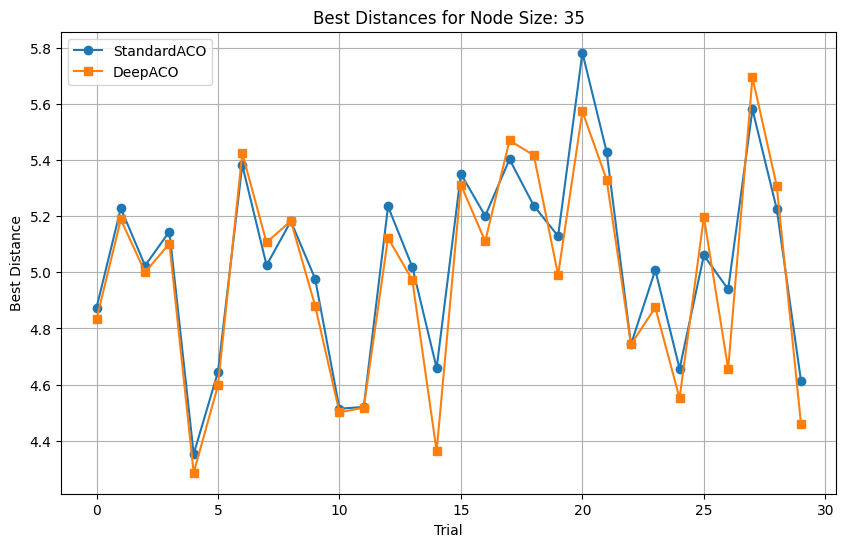


=== Node Size: 40 ===
Generating synthetic data for training...
Training Transformer Model...
Epoch 1/50, Train Loss: 182.7654, Val Loss: 1.3893
Epoch 2/50, Train Loss: 0.8623, Val Loss: 0.0583
Epoch 3/50, Train Loss: 0.4318, Val Loss: 0.0251
Epoch 4/50, Train Loss: 0.3664, Val Loss: 0.0244
Epoch 5/50, Train Loss: 0.3038, Val Loss: 0.0244
Epoch 6/50, Train Loss: 0.2252, Val Loss: 0.0249
Epoch 7/50, Train Loss: 0.1605, Val Loss: 0.0244
Epoch 8/50, Train Loss: 0.1431, Val Loss: 0.0244
Epoch 9/50, Train Loss: 0.1345, Val Loss: 0.0245
Epoch 10/50, Train Loss: 0.1266, Val Loss: 0.0245
Epoch 11/50, Train Loss: 0.1211, Val Loss: 0.0245
Epoch 12/50, Train Loss: 0.1178, Val Loss: 0.0245
Epoch 13/50, Train Loss: 0.1140, Val Loss: 0.0245
Epoch 14/50, Train Loss: 0.1113, Val Loss: 0.0245
Early stopping triggered.
Running 30 trials for node size 40...


Trials for node size 40:   3%|▎         | 1/30 [00:04<02:06,  4.36s/it]

Trial 1: StandardACO Best Distance = 5.7495, DeepACO Best Distance = 5.7180


Trials for node size 40:   7%|▋         | 2/30 [00:08<02:04,  4.44s/it]

Trial 2: StandardACO Best Distance = 5.1961, DeepACO Best Distance = 5.1731


Trials for node size 40:  10%|█         | 3/30 [00:13<01:59,  4.42s/it]

Trial 3: StandardACO Best Distance = 5.2579, DeepACO Best Distance = 5.4731


Trials for node size 40:  13%|█▎        | 4/30 [00:17<01:53,  4.37s/it]

Trial 4: StandardACO Best Distance = 5.5391, DeepACO Best Distance = 5.4579


Trials for node size 40:  17%|█▋        | 5/30 [00:21<01:47,  4.30s/it]

Trial 5: StandardACO Best Distance = 5.1121, DeepACO Best Distance = 5.0795


Trials for node size 40:  20%|██        | 6/30 [00:25<01:42,  4.27s/it]

Trial 6: StandardACO Best Distance = 5.5577, DeepACO Best Distance = 5.3574


Trials for node size 40:  23%|██▎       | 7/30 [00:30<01:40,  4.37s/it]

Trial 7: StandardACO Best Distance = 4.9641, DeepACO Best Distance = 4.8797


Trials for node size 40:  27%|██▋       | 8/30 [00:34<01:35,  4.33s/it]

Trial 8: StandardACO Best Distance = 5.7771, DeepACO Best Distance = 5.5707


Trials for node size 40:  30%|███       | 9/30 [00:38<01:30,  4.29s/it]

Trial 9: StandardACO Best Distance = 5.8061, DeepACO Best Distance = 5.7423


Trials for node size 40:  33%|███▎      | 10/30 [00:43<01:27,  4.36s/it]

Trial 10: StandardACO Best Distance = 6.0367, DeepACO Best Distance = 5.7800


Trials for node size 40:  37%|███▋      | 11/30 [00:47<01:22,  4.32s/it]

Trial 11: StandardACO Best Distance = 5.2093, DeepACO Best Distance = 5.4966


Trials for node size 40:  40%|████      | 12/30 [00:52<01:17,  4.33s/it]

Trial 12: StandardACO Best Distance = 5.4772, DeepACO Best Distance = 5.6594


Trials for node size 40:  43%|████▎     | 13/30 [00:56<01:13,  4.31s/it]

Trial 13: StandardACO Best Distance = 5.3301, DeepACO Best Distance = 5.4080


Trials for node size 40:  47%|████▋     | 14/30 [01:00<01:08,  4.27s/it]

Trial 14: StandardACO Best Distance = 5.6449, DeepACO Best Distance = 5.4676


Trials for node size 40:  50%|█████     | 15/30 [01:04<01:04,  4.29s/it]

Trial 15: StandardACO Best Distance = 5.3331, DeepACO Best Distance = 5.2981


Trials for node size 40:  53%|█████▎    | 16/30 [01:09<00:59,  4.27s/it]

Trial 16: StandardACO Best Distance = 5.4020, DeepACO Best Distance = 5.4916


Trials for node size 40:  57%|█████▋    | 17/30 [01:13<00:55,  4.26s/it]

Trial 17: StandardACO Best Distance = 5.6695, DeepACO Best Distance = 5.6524


Trials for node size 40:  60%|██████    | 18/30 [01:17<00:51,  4.26s/it]

Trial 18: StandardACO Best Distance = 5.5879, DeepACO Best Distance = 5.5690


Trials for node size 40:  63%|██████▎   | 19/30 [01:21<00:46,  4.26s/it]

Trial 19: StandardACO Best Distance = 5.1565, DeepACO Best Distance = 5.1121


Trials for node size 40:  67%|██████▋   | 20/30 [01:26<00:42,  4.30s/it]

Trial 20: StandardACO Best Distance = 5.4386, DeepACO Best Distance = 5.5166


Trials for node size 40:  70%|███████   | 21/30 [01:30<00:38,  4.33s/it]

Trial 21: StandardACO Best Distance = 5.1584, DeepACO Best Distance = 5.0002


Trials for node size 40:  73%|███████▎  | 22/30 [01:35<00:35,  4.49s/it]

Trial 22: StandardACO Best Distance = 5.5221, DeepACO Best Distance = 5.6274


Trials for node size 40:  77%|███████▋  | 23/30 [01:39<00:31,  4.46s/it]

Trial 23: StandardACO Best Distance = 5.4563, DeepACO Best Distance = 5.4508


Trials for node size 40:  80%|████████  | 24/30 [01:44<00:26,  4.40s/it]

Trial 24: StandardACO Best Distance = 5.6956, DeepACO Best Distance = 5.7389


Trials for node size 40:  83%|████████▎ | 25/30 [01:48<00:22,  4.42s/it]

Trial 25: StandardACO Best Distance = 5.4055, DeepACO Best Distance = 5.3181


Trials for node size 40:  87%|████████▋ | 26/30 [01:53<00:18,  4.58s/it]

Trial 26: StandardACO Best Distance = 4.8523, DeepACO Best Distance = 4.8509


Trials for node size 40:  90%|█████████ | 27/30 [01:57<00:13,  4.47s/it]

Trial 27: StandardACO Best Distance = 5.7594, DeepACO Best Distance = 5.7597


Trials for node size 40:  93%|█████████▎| 28/30 [02:02<00:08,  4.41s/it]

Trial 28: StandardACO Best Distance = 5.7404, DeepACO Best Distance = 5.9044


Trials for node size 40:  97%|█████████▋| 29/30 [02:06<00:04,  4.43s/it]

Trial 29: StandardACO Best Distance = 5.6481, DeepACO Best Distance = 5.4099


Trials for node size 40: 100%|██████████| 30/30 [02:10<00:00,  4.36s/it]

Trial 30: StandardACO Best Distance = 5.5070, DeepACO Best Distance = 5.5862


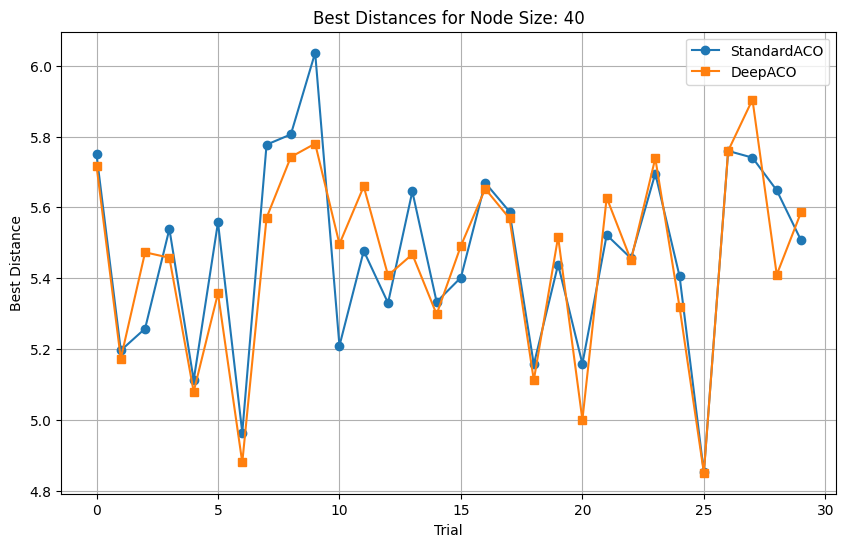


=== Statistical Significance Testing ===
Node Size 30: p-value = 9.0323e-01
Node Size 35: p-value = 3.6921e-02
Node Size 40: p-value = 4.5216e-01


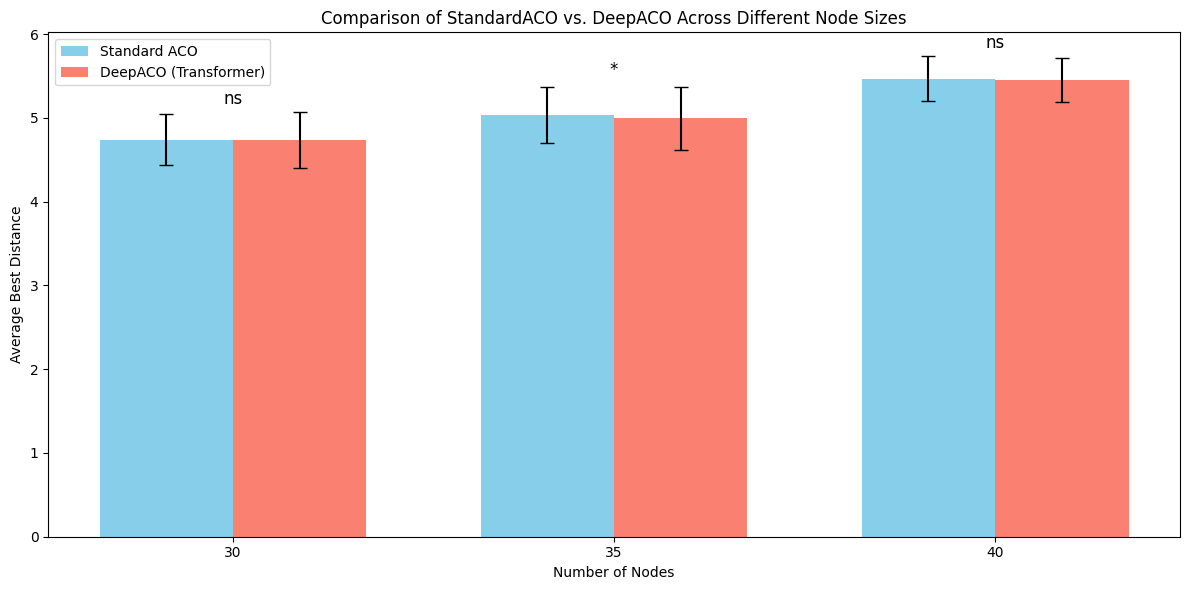

In [23]:
node_sizes = [30, 35, 40]

num_trials = 30
iterations = 50
num_ants = 20
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
Q = 100

results = run_experiment(
    node_sizes=node_sizes,
    num_trials=num_trials,
    iterations=iterations,
    num_ants=num_ants,
    alpha=alpha,
    beta=beta,
    evaporation_rate=evaporation_rate,
    Q=Q
)

print("\n=== Statistical Significance Testing ===")
p_values = perform_statistical_tests(results)

plot_results(results, p_values)
